In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
def fuzzy_checker(wrong_options,correct_options):
    names_array=[]
    ratio_array=[]    
    for wrong_option in wrong_options:
        if wrong_option in correct_options:
            names_array.append(wrong_option)
            ratio_array.append(100)
        else:   
            x=process.extractOne(wrong_option,correct_options,scorer=fuzz.token_set_ratio)
            names_array.append(x[0])
            ratio_array.append(x[1])
    return names_array,ratio_array


import info_utilities

In [30]:
data_folder = "../data/"

# Data loading and cleaning

## Users info

In [31]:
users      = pd.read_csv(f"{data_folder}users.csv")
users_info = pd.read_csv(f"{data_folder}users_info.csv",sep=";").set_index('attribute')

**Below the list of the columns and a short description**

In [32]:
users_info

,type,description
attribute,,
user_id,numeric,user id
archived,ordinal,"boolean: if a user is archived, is no more vis..."
user_type,mixed,types of the user in csv
classes,categorical,classes to which the user belongs
n_activities,interval,the number of user activities
n_recipes,interval,the number of user recipes
n_experiences,interval,the number of user experiences
n_reflections,interval,the number of user reflections
n_recipe_reflections,interval,the number of user's recipies reflections


In [33]:
info_utilities.check_columns(users,users_info)

No extra columns in info
There are 2 extra columns in df: ['user_name', 'companies']


In the df are present those type of users:

We need only formatore (supervisor), docente (teacher) and studente (student)

In [34]:
# a little translation from italian
vals_to_replace = {'formatore':'supervisor', 'docente':'teacher', 'studente':'student'}
users.replace({"user_type":vals_to_replace}, inplace=True)

In [35]:
# One hot for user_type
users = pd.concat(
                [users.loc[:, :'user_type'], 
                 (users['user_type'].str.split('\s*,\s*', expand=True)
                   .stack()
                   .str.get_dummies()
                   .sum(level=0)), 
                 users.loc[:, 'classes':]], 
                axis=1)

In [36]:
interval_features = users_info[users_info['type']=='interval'].index.tolist()

In [37]:
# fill with 0 the interval features
users.loc[:,interval_features] = users[interval_features].fillna(0)

In [38]:
students    = users[users['student'] == 1]
supervisors = users[users['supervisor'] == 1]
teachers    = users[users['teacher'] == 1]

### Loading notes

#### def join_by_fuzzy(df,df_to_match,
                  original_column,to_match_column,
                  to_join_column, joined_column, 
                  no_match_value=np.nan,limit=90):
    
    tmp_joined_name = '__fuzzy_result'
    
    str2Match = df[original_column].tolist()
    strOptions = df_to_match[to_match_column].tolist()
    name_match,ratio_match=fuzzy_checker(str2Match,strOptions)
    
    df1 = pd.DataFrame()
    df1['old_names']=pd.Series(str2Match)
    df1['correct_names']=pd.Series(name_match)
    df1['correct_ratio']=pd.Series(ratio_match)
    equiv=df_to_match.set_index(to_match_column).to_dict()[to_join_column]
    df1.loc[:,tmp_joined_name] = df1["correct_names"].map(equiv)
    df1.loc[df1['correct_ratio']<limit,tmp_joined_name] = no_match_value
    
    return df.assign(__fuzzy_result=df1[tmp_joined_name].values).rename({'__fuzzy_result': joined_column}, axis=1)

In [40]:
grades_1st = pd.read_csv(f"{data_folder}note_primi_anni.csv",sep="\t",names=["name","grade"])
grades_2nd = pd.read_csv(f"{data_folder}note_secondi_anni.csv",sep="\t",names=["name","grade"])
grades_3rd = pd.read_csv(f"{data_folder}note_terzi_anni.csv",sep="\t",names=["name","grade"])

In [41]:
students = join_by_fuzzy(students,grades_1st,'user_name','name','grade','grade_1st')
students = join_by_fuzzy(students,grades_2nd,'user_name','name','grade','grade_2nd')
students = join_by_fuzzy(students,grades_3rd,'user_name','name','grade','grade_3rd')

In [42]:
grades_1st[grades_1st.duplicated(['name'], keep=False)]

,name,grade
4,Dachille David,4.5
52,Poretti Victor,3.5
154,De Luca Carolyn,4.0
214,De Luca Carolyn,4.5
246,Dachille David,5.5
256,Poretti Victor,4.0


In [43]:
grades_2nd[grades_2nd.duplicated(['name'], keep=False)]

,name,grade
28,Fontana Loris,4.5
58,Fontana Loris,4.5
84,Poretti Victor,2.0
143,Poretti Victor,3.5


In [44]:
grades_3rd[grades_3rd.duplicated(['name'], keep=False)]

,name,grade
18,Spiegel Fabio,5.0
125,Spiegel Fabio,2.5


In [48]:
filter_grades = (((students['grade_2nd'].notnull()) & (students['grade_1st'].isnull())) | (students['grade_3rd'].notnull()) & ((students['grade_1st'].isnull()) | (students['grade_2nd'].isnull())))

In [49]:
students[filter_grades][['user_name','grade_1st','grade_2nd','grade_3rd']]

,user_name,grade_1st,grade_2nd,grade_3rd
43,Balzio Fabio,NaN,NaN,4.5
44,Campana Luca,NaN,NaN,5.5
45,Grana Luigi,NaN,NaN,5.5
46,Mondada Alessio,NaN,NaN,6.0
48,Pedrucci Gioele,NaN,NaN,5.0
49,Saldarini Lorenzo,NaN,NaN,4.5
51,Stalder Zeno,NaN,NaN,5.0
127,Daniel Grumelli,NaN,5.0,4.5
128,Cesare Pedrazzani,NaN,5.0,4.5
191,Marvin Borioli,NaN,4.5,4.5


## Activities info

In [15]:
activities      = pd.read_csv(f"{data_folder}activities.csv")
activities_info = pd.read_csv(f"{data_folder}activities_info.csv", sep=";").set_index("attribute")

**Below the list of the columns and a short description**

In [16]:
activities_info

,type,description
attribute,,
activity_id,numeric,activity id
user_id,numeric,user id
at_activityType,categorical,"type of the activity ['recipe','experience']"
len_description,interval,the length of the description
ac_atSchool,ordinal,"boolean, if the recipe was done at school"
ac_atInteraziendale,ordinal,"boolean, if the recipe was done in an ""special..."
ac_atCompany,ordinal,"boolean, the recipe was done in the company"
avg_step_len,interval,average step length
n_steps,interval,the number of steps of the activity


In [17]:
info_utilities.check_columns(activities,activities_info)

There are 2 extra columns in info: ['user_id', 'activity_id']
There are 14 extra columns in df: ['activity_school_year', 'std_step_len', 'activity_total_length', 'start_year', 'us_user', 'ac_activity', 'len_miglioramenti', 'len_critici', 'len_competenze', 'n_edits', 'len_observations', 'len_bilancio', 'len_steps', 'std_reflection_length']


------

# Data exploring

## Users

In [18]:
df = students[students['grade_1st'] != np.nan]

In [19]:
palette = ['#b41414','#b41414','#b41414','#b41414','#b41414','#b41414', '#b44714', '#b47414', 
           '#b49a14', '#abb414', '#70b414', 
           '#3db414', '#14b414', '#14b441']

In [20]:
notes = [np.nan,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
color_map = dict(zip(notes,palette))

In [21]:
colors = df['grade_1st'].map(color_map)

In [22]:
corr_matrix = df.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
n = 4
top_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=True))[:n]

In [23]:
interesting_cols = list(set(list(zip(*top_corr.keys().values))[0]+list(zip(*top_corr.keys().values))[1]))

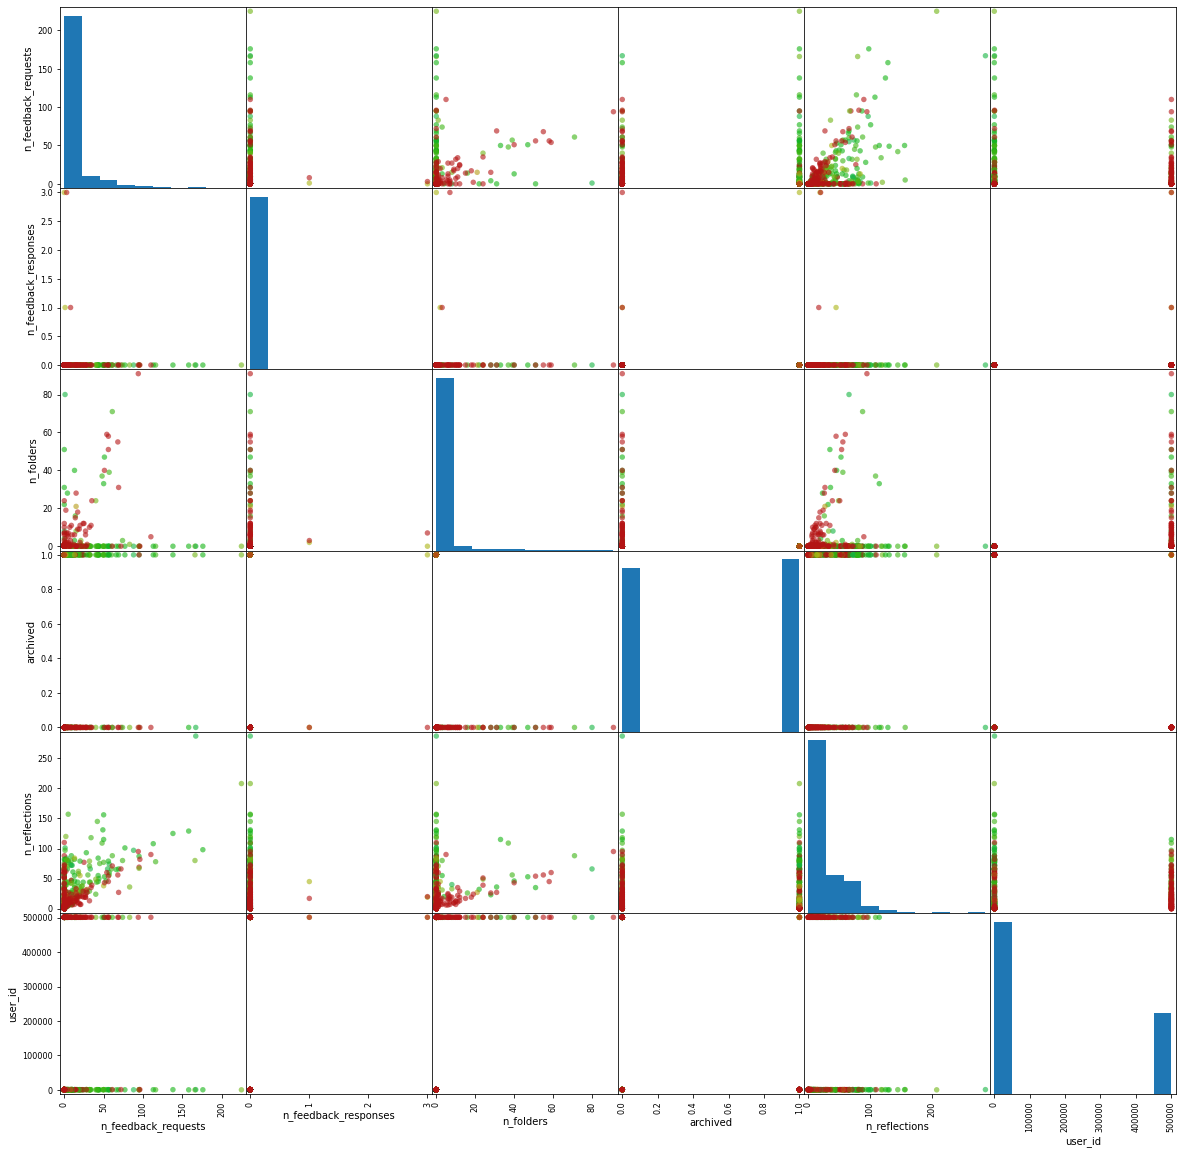

In [24]:
g = pd.plotting.scatter_matrix(df[interesting_cols], figsize=(20,20), marker = 'o', hist_kwds = {'bins': 10}, s = 30, alpha = 0.6, color=colors)
plt.show()
#sns.pairplot(supervisors[supervisors_interesting_cols]);

In [42]:
hist = students[interval_features].hist(bins=20,figsize=[18,50],layout=(11,2))

ValueError: Layout of 11x2 must be larger than required size 23

<Figure size 1296x3600 with 0 Axes>

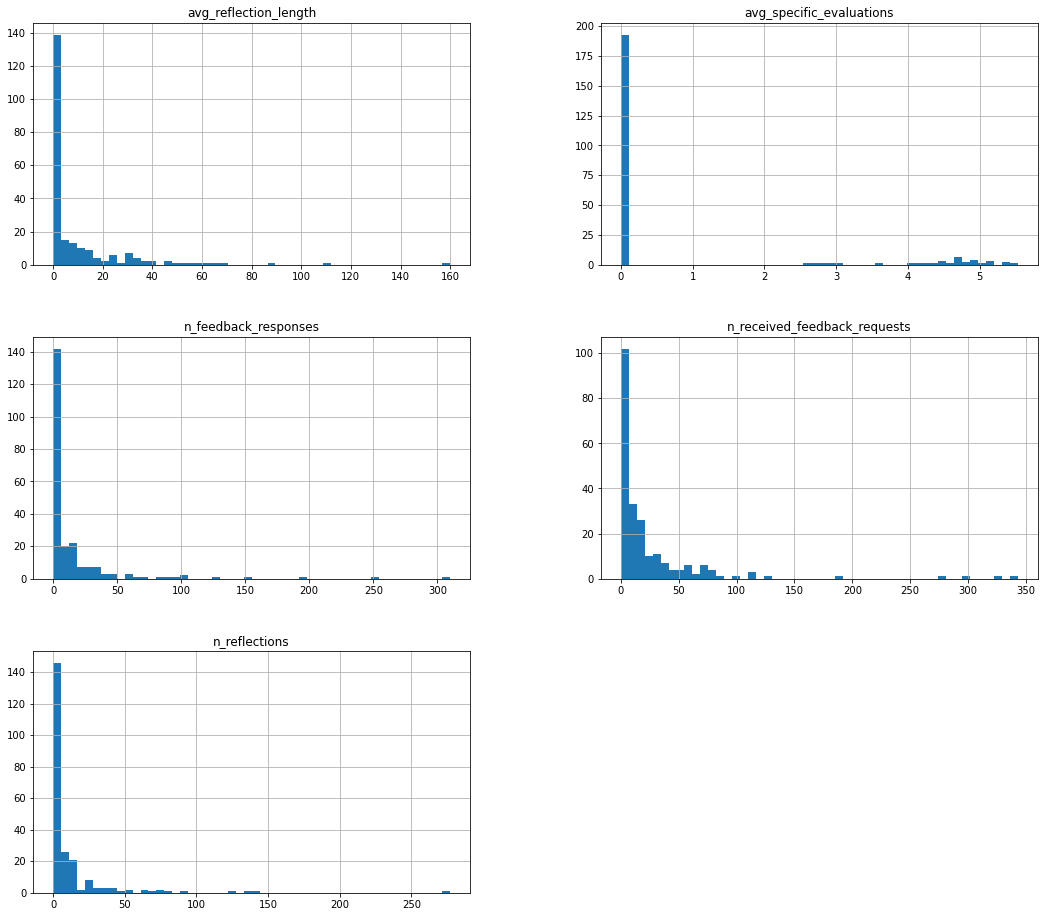

In [43]:
supervisors_interesting_cols = ['avg_reflection_length','avg_specific_evaluations','n_feedback_responses','n_received_feedback_requests','n_reflections']
hist = supervisors[supervisors_interesting_cols].hist(bins=50,figsize=[18,16],layout=(3,2))

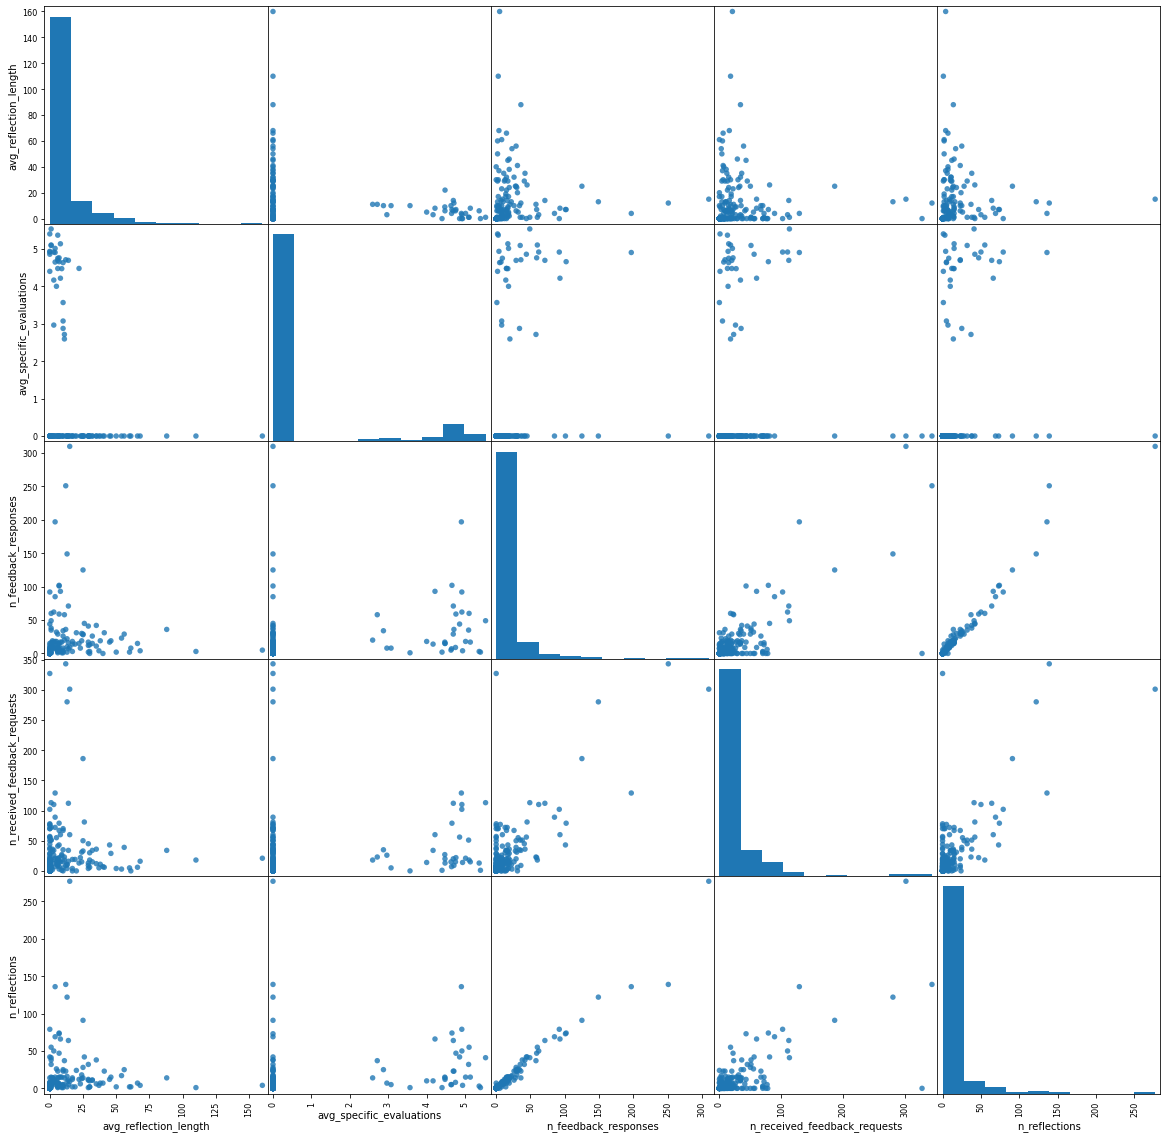

In [44]:
g = pd.plotting.scatter_matrix(supervisors[supervisors_interesting_cols], figsize=(20,20), marker = 'o', hist_kwds = {'bins': 10}, s = 30, alpha = 0.8)
plt.show()